In [1]:
import xarray as xr
import xskillscore as xs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yaml
import geopandas as gpd

In [2]:
base_test_path = "/data/dl20-data/climate_operational/Victor_data/preprocessed_datasets_NN_new/test/"
base_prediction_path = "/data/dl20-data/climate_operational/Victor_data/predicted_datasets_NN_new/"

# 1) Plot monthly and annual test performance metrics

In [3]:
# seasonal test scores
seasonal_df = pd.read_csv("/home/vgarcia/experiments/ML_seasonal_new/Optimize_ML_all/Optimize_ML_all_testing.csv")

# Calculate weighted score
seasonal_df["weighted_score_rx90p_anom"] = 0.7 * seasonal_df["R2_rx90p_anom"] - 0.3 * seasonal_df["MAE_rx90p_anom"]
seasonal_df["weighted_score_pr_anom"] = 0.7 * seasonal_df["R2_pr_anom"] - 0.3 * seasonal_df["MAE_pr_anom"]


seasonal_df["Model"] = [model + "_All" if model in ["Lasso", "HGBR"] else model for model in seasonal_df["Model"]]


In [4]:
def merge_testing_csvs(csv1, csv2):
    # Load both CSVs
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)

    # Merge (row-wise)
    merged_df = pd.concat([df1, df2], ignore_index=True)

    return merged_df


In [5]:
# import annual test scores
annual_df = merge_testing_csvs("/home/vgarcia/experiments/ML_annual_new/Optimize_ML_all_Orinoco/Optimize_ML_all_Orinoco_testing.csv", 
                               "/home/vgarcia/experiments/NN_annual_new/test_metrics.csv")

# Calculate weighted score for each indicator
annual_df["weighted_score_rx90p_anom"] = 0.7 * annual_df["R2_rx90p_anom"] - 0.3 * annual_df["MAE_rx90p_anom"]
annual_df["weighted_score_pr_anom"] = 0.7 * annual_df["R2_pr_anom"] - 0.3 * annual_df["MAE_pr_anom"]

annual_df = annual_df.drop(index=[3,4])

annual_df["Model"] = [model + "_All" if model in ["Lasso", "HGBR"] else model for model in annual_df["Model"]]


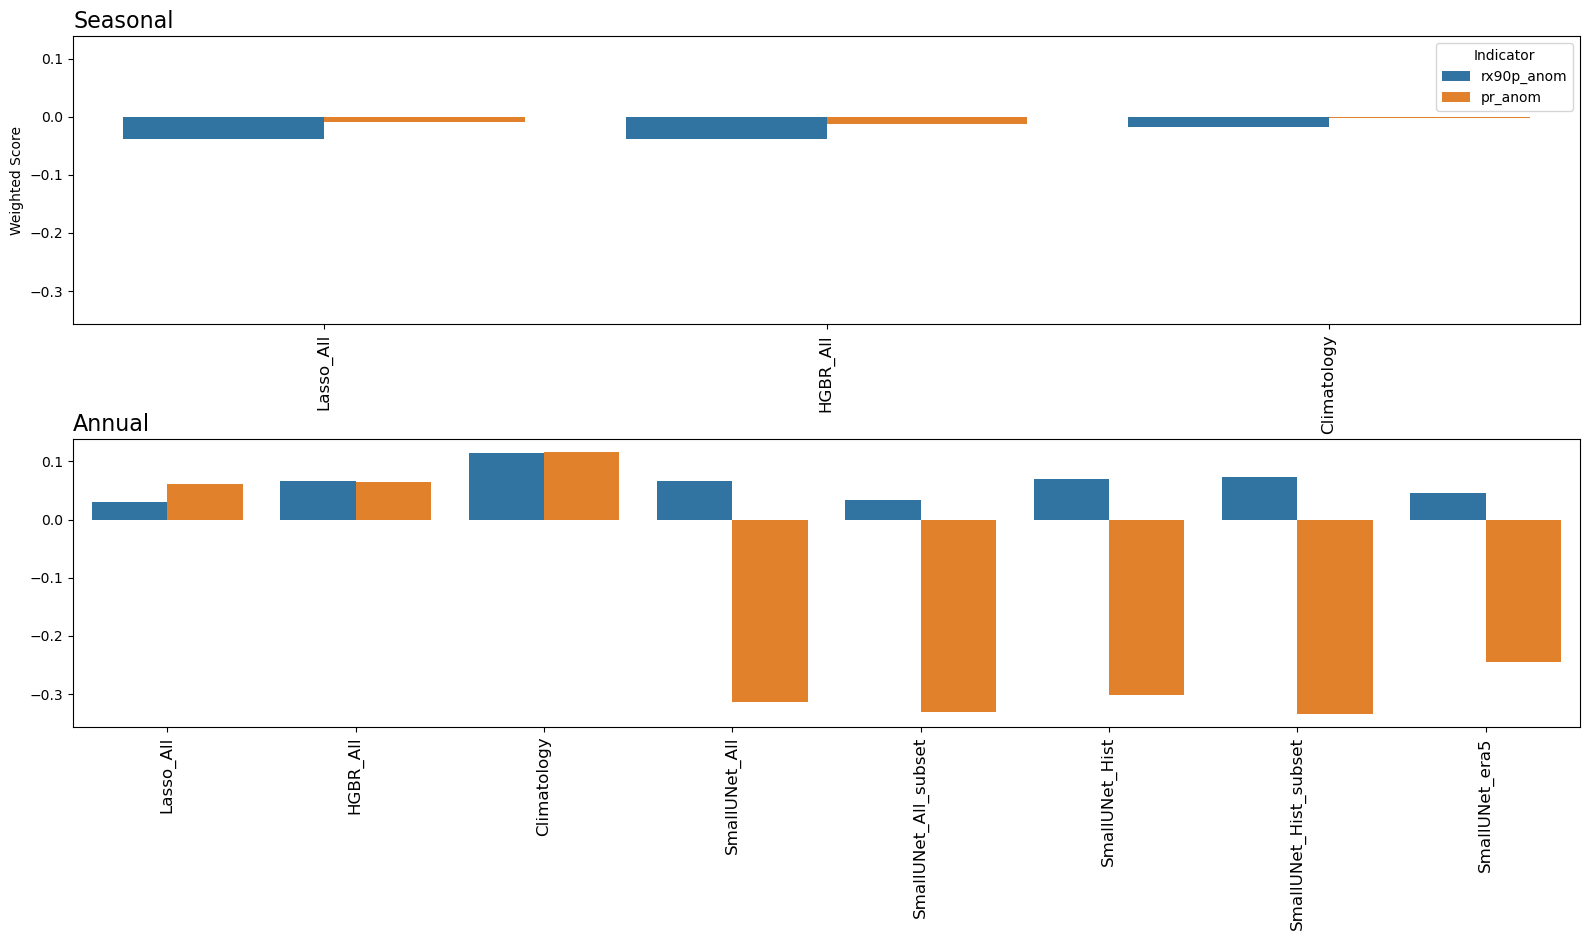

In [37]:
### Plot weighted score ###

# transform dataset
score_df1 = seasonal_df[["Model", "weighted_score_rx90p_anom", "weighted_score_pr_anom"]].melt(
    id_vars="Model", var_name="Indicator", value_name="Score"
)
score_df2 = annual_df[["Model", "weighted_score_rx90p_anom", "weighted_score_pr_anom"]].melt(
    id_vars="Model", var_name="Indicator", value_name="Score"
)

score_df1["Indicator"] = score_df1["Indicator"].str.replace("weighted_score_", "")
score_df2["Indicator"] = score_df2["Indicator"].str.replace("weighted_score_", "")

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=True)

sns.barplot(data=score_df1, x="Model", y="Score", hue="Indicator", ax=axes[0])
axes[0].set_title("Seasonal", loc="left", size=16)
axes[0].set_xlabel("")
axes[0].set_ylabel("Weighted Score")
axes[0].tick_params(axis='x', rotation=90, labelsize=12)
axes[0].title.set_fontweight('bold')

sns.barplot(data=score_df2, x="Model", y="Score", hue="Indicator", ax=axes[1], legend=False)
axes[1].set_title("Annual", loc="left", size=16)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', rotation=90, labelsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.4)  # Increase vertical spacing
plt.show()



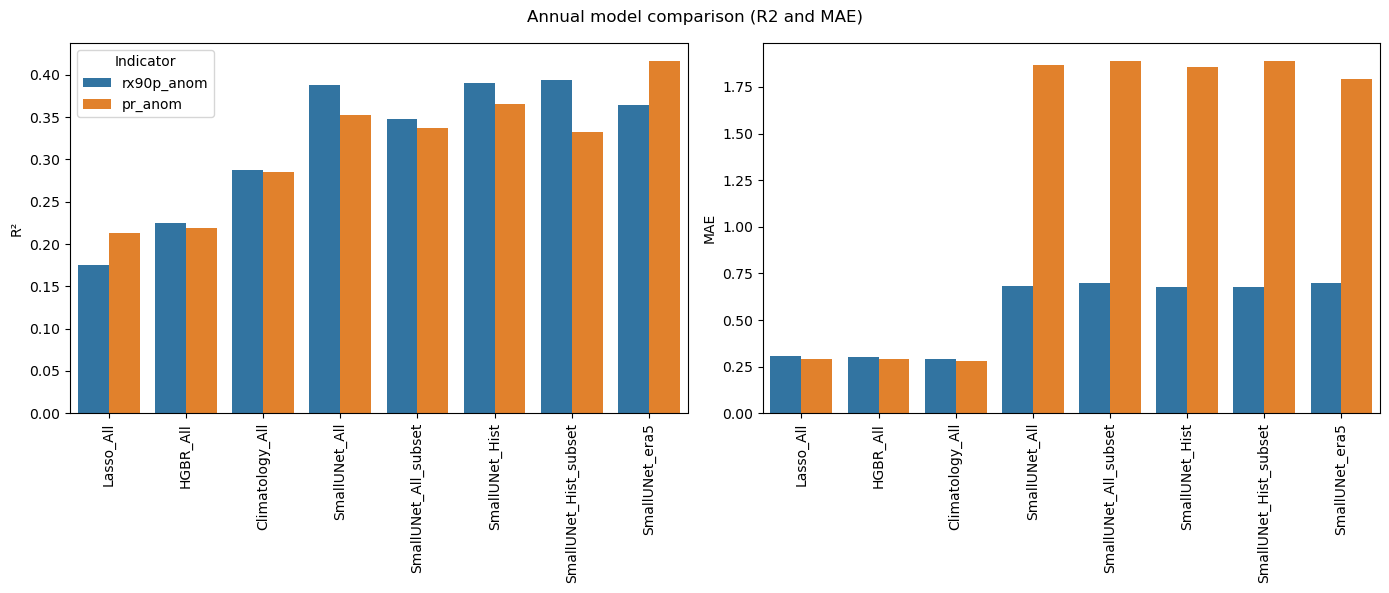

In [20]:
### Plot R2 and MAE ###

# Transform dataframe
r2_df = annual_df[["Model", "R2_rx90p_anom", "R2_pr_anom"]].melt(id_vars="Model", 
                                                          var_name="Indicator", 
                                                          value_name="R2")
mae_df = annual_df[["Model", "MAE_rx90p_anom", "MAE_pr_anom"]].melt(id_vars="Model", 
                                                              var_name="Indicator", 
                                                              value_name="MAE")

r2_df["Indicator"] = r2_df["Indicator"].str.replace("R2_", "")
mae_df["Indicator"] = mae_df["Indicator"].str.replace("MAE_", "")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

sns.barplot(data=r2_df, x="Model", y="R2", hue="Indicator", ax=axes[0])
axes[0].set_xlabel("")
axes[0].set_ylabel("R²")
axes[0].tick_params(axis='x', rotation=90)


sns.barplot(data=mae_df, x="Model", y="MAE", hue="Indicator", ax=axes[1], legend=False)
axes[1].set_ylabel("MAE")
axes[1].set_xlabel("")
axes[1].tick_params(axis='x', rotation=90)

fig.suptitle("Annual model comparison (R2 and MAE)")
plt.tight_layout()
plt.show()


# 2) Temporal evolution of the score

In [23]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [24]:
# Import and calculate R2, MAE and weighted score for each year
observed_da = xr.open_zarr(
    f"{base_test_path}annual_da.zarr"
)

experiments = ["SmallUNet_All_subset_predicted"]

results = []

for experiment in experiments:
    print(f"Processing: {experiment}")
    
    # Open predicted data
    predicted_path = f"{base_prediction_path}{experiment}.zarr"
    predicted_da = xr.open_zarr(predicted_path)

    # Chunk spatial dimensions
    pred = predicted_da["predicted_annual"].chunk({"lat": -1, "lon": -1})
    obs = observed_da["annual_maps"].chunk({"lat": -1, "lon": -1})

    # Compute metrics over space
    r2 = xs.r2(pred, obs, dim=["lat", "lon"], skipna=True)
    mae = xs.mae(pred, obs, dim=["lat", "lon"], skipna=True)
    score = 0.7 * r2 - 0.3 * mae

    # Loop over variable_index (assume it's 2)
    df = pd.DataFrame({
        "dataset": experiment,
        "year": score["year"].values,
        "score_pr_anom": score.isel(variable_index=0).values,
        "score_rx90p_anom": score.isel(variable_index=1).values
    })

    results.append(df)

results_df = pd.concat(results, ignore_index=True)

Processing: SmallUNet_All_subset_predicted


In [26]:
# transform dataframe
long_df = pd.melt(
    results_df,
    id_vars=["dataset", "year"],
    value_vars=["score_pr_anom", "score_rx90p_anom"],
    var_name="variable",
    value_name="score"
)

long_df = long_df.dropna(subset=["score"])

In [30]:
# load years that are Niño, Niña and neutral
with open('/data/dl20-data/climate_operational/Victor_data/climate_index/NASA-ENSO_years.yaml', 'r') as file:
    ENSO_dict = yaml.safe_load(file)

enso_colors = {
    "niño": "red",
    "niña": "blue",
    "neutral": "lightgrey"
}


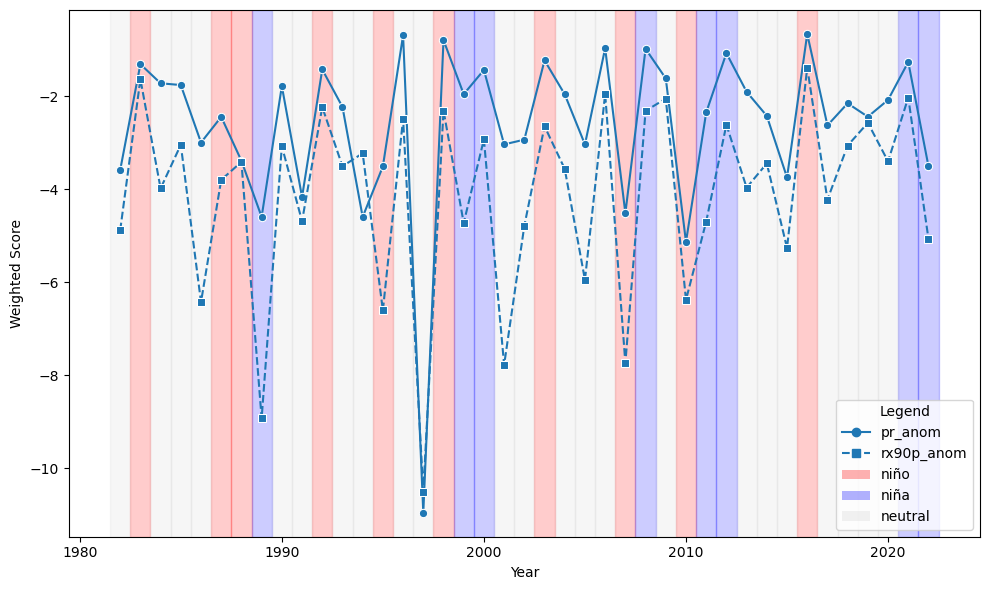

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# ENSO background shading
min_year, max_year = long_df["year"].min(), long_df["year"].max()
for phase, years in ENSO_dict.items():
    for year in years:
        if min_year <= year <= max_year:
            ax.axvspan(year - 0.5, year + 0.5, color=enso_colors[phase], alpha=0.2, zorder=0)

# Plot pr_anom
line_pr = sns.lineplot(
    data=long_df[long_df["variable"] == "score_pr_anom"],
    x="year", y="score", hue="dataset", marker="o", linestyle='-', ax=ax, legend=False
)

# Plot rx90p_anom
line_rx = sns.lineplot(
    data=long_df[long_df["variable"] == "score_rx90p_anom"],
    x="year", y="score", hue="dataset", marker="s", linestyle='--', ax=ax
)

# Labels
ax.set_xlabel("Year")
ax.set_ylabel("Weighted Score")

# Remove dataset legend if it exists
if ax.legend_:
    ax.legend_.remove()

# Use actual plot colors
color_pr = line_pr.lines[0].get_color()
color_rx = line_rx.lines[0].get_color()

# Variable legend
variable_lines = [
    Line2D([0], [0], color=color_pr, linestyle='-', marker='o', label='pr_anom'),
    Line2D([0], [0], color=color_rx, linestyle='--', marker='s', label='rx90p_anom')
]

# ENSO legend
visible_phases = [phase for phase, years in ENSO_dict.items() if any(min_year <= y <= max_year for y in years)]
enso_patches = [Patch(facecolor=enso_colors[phase], alpha=0.3, label=phase) for phase in visible_phases]

# Final legend
ax.legend(variable_lines + enso_patches, [h.get_label() for h in variable_lines + enso_patches],
          title="Legend", loc='lower right')

plt.tight_layout()
plt.show()


## Does each ENSO phase have different error?

In [35]:
predicted_path = "/data/dl20-data/climate_operational/Victor_data/predicted_datasets_NN_new/SmallUNet_All_subset_predicted.zarr"
predicted_da = xr.open_zarr(predicted_path)["predicted_annual"]
annual_da = xr.open_zarr(
    "/data/dl20-data/climate_operational/Victor_data/preprocessed_datasets_NN_new/test/annual_da.zarr"
)["annual_maps"]


In [36]:
# Create a dictionary to hold the phase-specific data
corr_dict = {}

phase_results = []
for phase, years in ENSO_dict.items():

    # predicted da
    mask = pred['year'].isin(years)
    predicted_phase = pred.sel(year=mask)

    # observed da
    mask = obs['year'].isin(years)
    observed_phase = obs.sel(year=mask)

    r2 = xs.r2(predicted_phase, observed_phase, dim=["lat", "lon"], skipna=True)
    mse = xs.mse(predicted_phase, observed_phase, dim=["lat", "lon"], skipna=True)
    score = 0.7 * r2 - 0.3 * mse

    # Loop over variable_index (assume it's 2)
    df = pd.DataFrame({
        "phase": phase,
        "year": score["year"].values,
        "score_pr_anom": score.isel(variable_index=0).values,
        "score_rx90p_anom": score.isel(variable_index=1).values
    })

    phase_results.append(df)
phase_df = pd.concat(phase_results, ignore_index=True)

In [ ]:
# ANOVA test
from scipy.stats import f_oneway, kruskal

groups_pr = [phase_df[phase_df['phase'] == phase]['score_pr_anom'] for phase in phase_df['phase'].unique()]
groups_rx = [phase_df[phase_df['phase'] == phase]['score_rx90p_anom'] for phase in phase_df['phase'].unique()]

# ANOVA tests
anova_pr = f_oneway(*groups_pr)
anova_rx = f_oneway(*groups_rx)

print("ANOVA results for score_pr_anom:", anova_pr)
print("ANOVA results for score_rx90p_anom:", anova_rx)


ANOVA results for score_pr_anom: F_onewayResult(statistic=np.float64(0.46522348199704144), pvalue=np.float64(0.6315240979893413))
ANOVA results for score_rx90p_anom: F_onewayResult(statistic=np.float64(0.6630454158881878), pvalue=np.float64(0.5211389747143662))


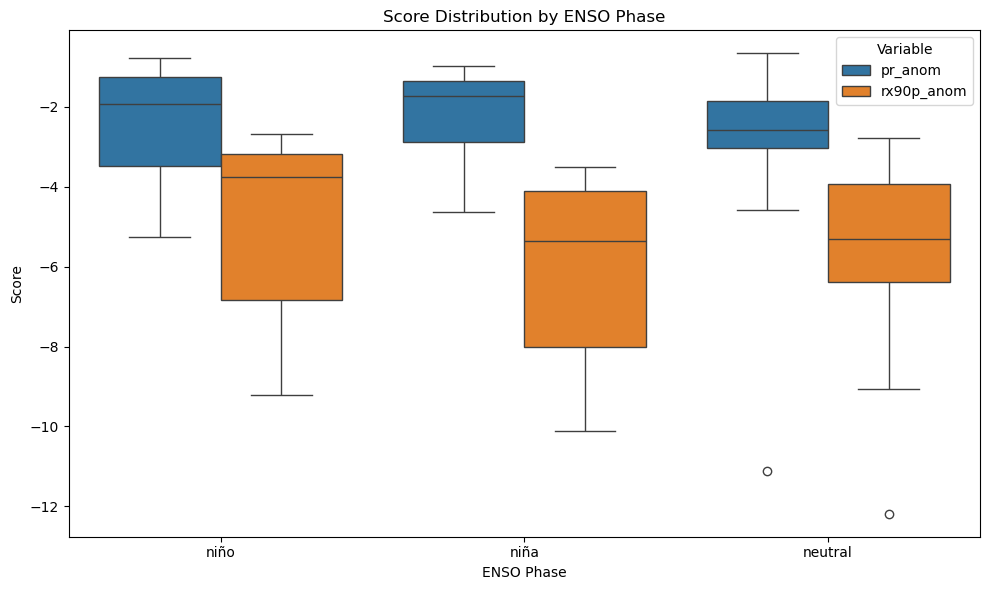

In [40]:
# Intervals

# Reshape phase_df to long format
melted = pd.melt(
    phase_df,
    id_vars=["phase"],
    value_vars=["score_pr_anom", "score_rx90p_anom"],
    var_name="variable",
    value_name="score"
)

# Rename variables for better axis labeling
melted["variable"] = melted["variable"].replace({
    "score_pr_anom": "pr_anom",
    "score_rx90p_anom": "rx90p_anom"
})

# Create single plot
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=melted,
    x="phase",
    y="score",
    hue="variable"
)

# Title and labels
plt.title("Score Distribution by ENSO Phase")
plt.xlabel("ENSO Phase")
plt.ylabel("Score")
plt.legend(title="Variable")

plt.tight_layout()
plt.show()


## PCA analysis

In [7]:
from sklearn.decomposition import PCA

df = pd.read_csv("/data/dl20-data/climate_operational/Victor_data/preprocessed_datasets_ML_new/test/test.csv")
df = df.drop(["rx90p_anom", "pr_anom"], axis = 1)
df_clean = df.dropna(axis=1, how='any')

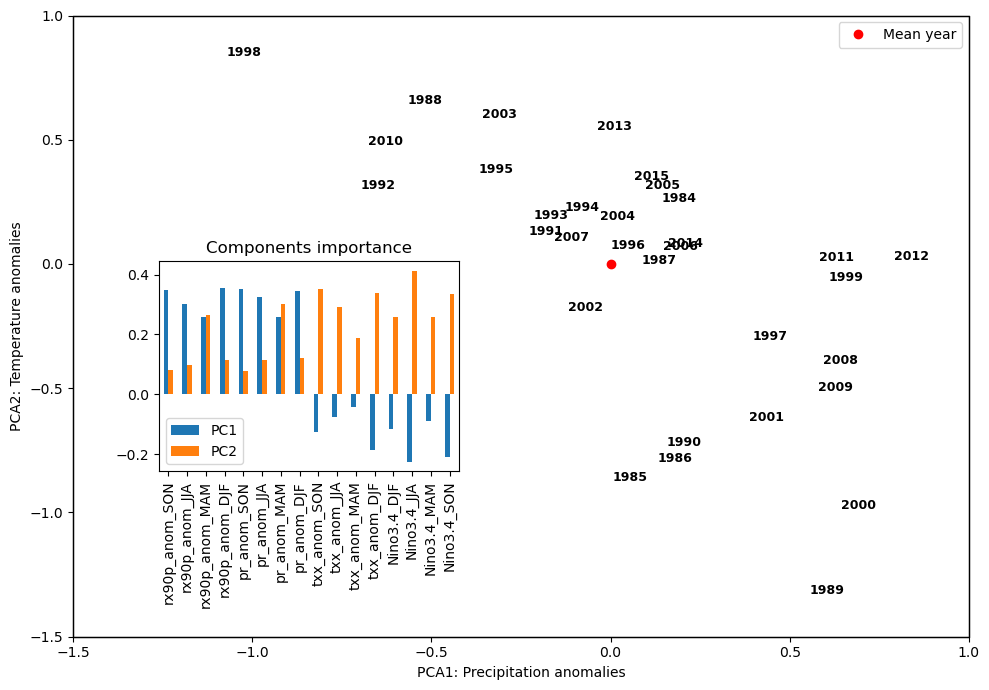

In [ ]:
# remove lat, lon and time
variables = [col for col in df_clean.columns if col not in ['year', 'lat', 'lon']]
data = df_clean[variables]

# PCA transformation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

# Add PCA coordinates back to the DataFrame
df_clean['PCA1'] = X_pca[:, 0]
df_clean['PCA2'] = X_pca[:, 1]

# Plot all points with year labels
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(X_pca[:,0], X_pca[:,1], color='lightblue', edgecolor='k', alpha=0)

# Calculate and plot the centroid for each year
centroids = df_clean.groupby('year')[['PCA1', 'PCA2']].mean()

# Plot centroids with larger markers
mean_x = centroids['PCA1'].mean()
mean_y = centroids['PCA2'].mean()
ax.plot(mean_x, mean_y, 'ro', label='Mean year')

# Add year labels next to centroids
for year, row in centroids.iterrows():
    ax.annotate(str(year), (row['PCA1'], row['PCA2']), fontsize=9, fontweight='bold')

ax.set_xlabel("PCA1: Precipitation anomalies")
ax.set_ylabel("PCA2: Temperature anomalies")
ax.set_xlim(-1.5, 1)
ax.set_ylim(-1.5, 1)
ax.legend(loc = 'upper right')
ax.grid(False)
plt.tight_layout()

# --- Add loadings bar plot at bottom right ---
loadings = pca.components_
loadings_df = pd.DataFrame(loadings.T, index=variables, columns=['PC1', 'PC2'])

# Create inset axes at bottom right
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create inset axes at bottom left but shifted to the right
ax_inset = inset_axes(
    ax,
    width="100%",  # or specify in absolute units, e.g., 0.35
    height="100%",
    bbox_to_anchor=(0.15, 0.30, 0.3, 0.3),  # x, y, width, height in axes fraction
    loc='lower left',
    borderpad=1,
    bbox_transform=fig.transFigure
)

# Plot bar chart of loadings
loadings_df[['PC1', 'PC2']].plot(kind='bar', ax=ax_inset)
ax_inset.set_title('Components importance')
ax_inset.tick_params(axis='x', rotation=90)

# Add a black border around the inset axes
# Get the position of the inset axes in display coordinates
pos = ax_inset.get_position()

# Add a rectangle patch as a border
import matplotlib.patches as patches
border = patches.Rectangle(
    (pos.x0, pos.y0), pos.width, pos.height,
    linewidth=1, edgecolor='black', facecolor='none', transform=fig.transFigure, zorder=10
)
fig = plt.gcf()
fig.patches.append(border)

plt.show()

# 3) Score spatial distribution

In each zone, what is the score? use a accumulated graph to see that most of the score is in X zone

In [10]:
experiment = "SmallUNet_All_predicted"
observed_da = xr.open_zarr(
    f"{base_test_path}annual_da.zarr"
)

predicted_path = f"{base_prediction_path}{experiment}.zarr"
predicted_da = xr.open_zarr(
    f"{predicted_path}"
)

In [14]:
# calculate r2 and MSE 
# are scores differently calculated??
r2 = xs.r2(predicted_da["predicted_annual"], observed_da["annual_maps"], dim="year")
mae = xs.mae(predicted_da["predicted_annual"], observed_da["annual_maps"], dim="year")

score = 0.7 * r2 - 0.3 * mae


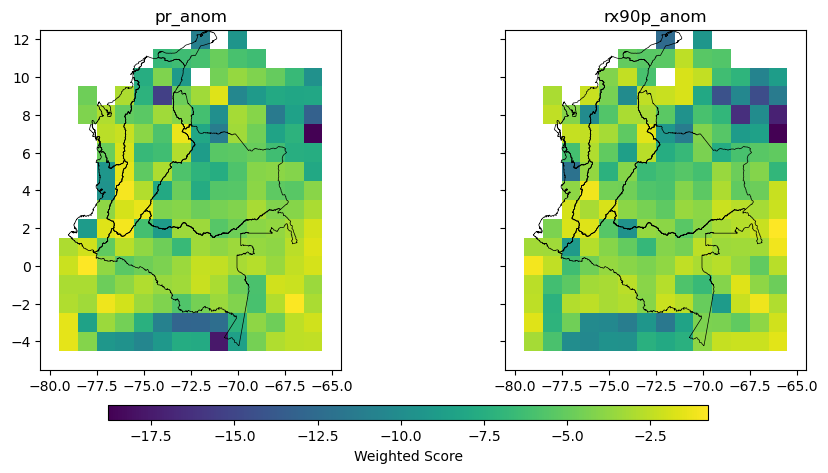

In [15]:
# Load shapefile
shapefile = gpd.read_file("/data/dl20-data/climate_operational/Victor_data/cuencas_colombia/")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot the data without colorbars
im0 = score.isel(variable_index=0).plot(ax=axes[0], add_colorbar=False)
axes[0].set_title("pr_anom")
axes[0].set_xlabel('')
axes[0].set_ylabel('')

im1 = score.isel(variable_index=1).plot(ax=axes[1], add_colorbar=False)
axes[1].set_title("rx90p_anom")

# Remove y-axis labels and ticks from the second plot
axes[1].set_ylabel('')
axes[1].yaxis.set_tick_params(labelleft=False)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Plot shapefile first on both axes
shapefile.plot(ax=axes[0], facecolor='none', edgecolor='black', linewidth=0.5, column="NOM_AH")
shapefile.plot(ax=axes[1], facecolor='none', edgecolor='black', linewidth=0.5, column="NOM_AH")

# Adjust layout before adding colorbar
fig.subplots_adjust(bottom=0.20, wspace=0)

# Add shared colorbar
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Weighted Score')

plt.show()


<Figure size 1200x600 with 0 Axes>

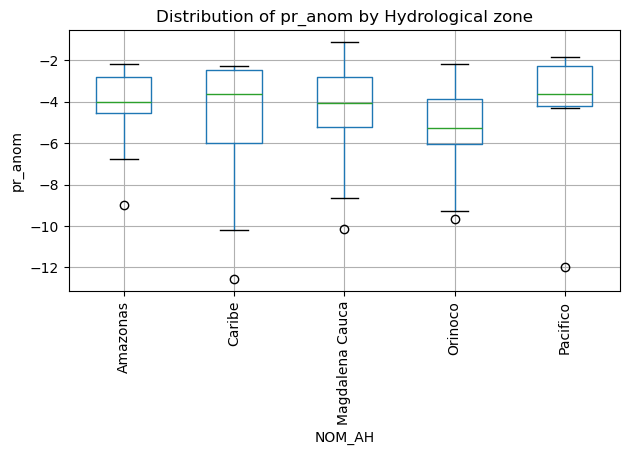

In [ ]:
# Check mean in different hydrological zones
from shapely.geometry import Point

# Load shapefile
shapefile = gpd.read_file("/data/dl20-data/climate_operational/Victor_data/cuencas_colombia/")

# Extract one variable as example
da = score.isel(variable_index=1)  # For example, pr_anom

# Flatten the xarray DataArray into a DataFrame with lat, lon, and values
df_points = da.to_dataframe(name='value').reset_index()

# Create geometry column from lat/lon
df_points['geometry'] = [Point(xy) for xy in zip(df_points['lon'], df_points['lat'])]

# Convert to GeoDataFrame
gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry')

# Make sure CRS matches between points and shapefile
# If your shapefile has a CRS, set it for points too, for example:
gdf_points.crs = shapefile.crs

# Spatial join: assign each point to a polygon from shapefile
gdf_joined = gpd.sjoin(gdf_points, shapefile[['NOM_AH', 'geometry']], how='inner', predicate='within')

# Now group by NOM_AH and plot boxplots of 'value'
plt.figure(figsize=(12,6))
gdf_joined.boxplot(column='value', by='NOM_AH', rot=90)
plt.title('Distribution of pr_anom by Hydrological zone')
plt.suptitle('')
plt.xlabel('')
plt.ylabel('pr_anom')
plt.tight_layout()
plt.show()
